# Topic Modeling mit MALLET


**Dieses Notebook basiert auf IntroducingMallet.ipynb von [DARIAH-DE](https://github.com/DARIAH-DE/Topics), Mai 2019.** <br>
Alle Erklärungen auf Englisch sind Zitate von DARIAH-DE. 

## Bibliotheken importieren


In [81]:
from cophi_toolbox import preprocessing
from dariah_topics import utils
from dariah_topics import postprocessing
from dariah_topics import visualization
import metadata_toolbox.utils as metadata
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## 1. Vorverarbeitung

### 1.1. Korpus auslesen


In [85]:
data = 'C:/mallet-2.0.8'
path_to_corpus = Path('Z:/TM_Schuchardt/hsa_spa_chunks_100') 

In [86]:
pattern = '{id}_{sender}_an_{reciever}_{date}_{language}_{chunk}' 
# z.B. 3048_Hugo Schuchardt_an_Ernst Dümmler_1902-05-28_deu_00

#### Zugriff auf Metadaten


In [87]:
meta = pd.concat([metadata.fname2metadata(str(path), pattern=pattern) for path in path_to_corpus.glob('*.txt')])

In [88]:
meta[:5] # by adding '[:5]' to the variable, only the first 5 elements will be printed

,id,sender,reciever,date,language,chunk
Z:\TM_Schuchardt\hsa_spa_chunks_100\101_Antonio-Machado-y-Álvarez_an_Hugo-Schuchardt_1881-09-03_spa_0000.txt,101,Antonio-Machado-y-Álvarez,Hugo-Schuchardt,1881-09-03,spa,0000
Z:\TM_Schuchardt\hsa_spa_chunks_100\101_Antonio-Machado-y-Álvarez_an_Hugo-Schuchardt_1881-09-03_spa_0001.txt,101,Antonio-Machado-y-Álvarez,Hugo-Schuchardt,1881-09-03,spa,0001
Z:\TM_Schuchardt\hsa_spa_chunks_100\101_Antonio-Machado-y-Álvarez_an_Hugo-Schuchardt_1881-09-03_spa_0002.txt,101,Antonio-Machado-y-Álvarez,Hugo-Schuchardt,1881-09-03,spa,0002
Z:\TM_Schuchardt\hsa_spa_chunks_100\101_Antonio-Machado-y-Álvarez_an_Hugo-Schuchardt_1881-09-03_spa_0003.txt,101,Antonio-Machado-y-Álvarez,Hugo-Schuchardt,1881-09-03,spa,0003
Z:\TM_Schuchardt\hsa_spa_chunks_100\101_Antonio-Machado-y-Álvarez_an_Hugo-Schuchardt_1881-09-03_spa_0004.txt,101,Antonio-Machado-y-Álvarez,Hugo-Schuchardt,1881-09-03,spa,0004


#### Aufgelistete Dokumente auslesen

In [89]:
corpus = list(preprocessing.read_files(meta.index))
corpus[0][:255] # printing the first 255 characters of the first document

'Querido amigar ante todo no me pedir V nunca mi seña por que ya ser comer aquel célebre médico inglés a quien llegar los carta con sólo poner en el sobrar Magni Boerhavi in tota Europa Médico con poner Antonio Machado y Alvarez en Sevilla lo carta llegar '

### 1.3. Korpus tokenisieren 


In [90]:
tokenized_corpus = [list(preprocessing.tokenize(document)) for document in corpus]

In [91]:
tokenized_corpus[0][0:13]

['querido',
 'amigar',
 'ante',
 'todo',
 'no',
 'me',
 'pedir',
 'nunca',
 'mi',
 'seña',
 'por',
 'que',
 'ya']

### 1.4 document-term matrix kreieren
#### 1.4.1 Matrix für große Korpora


In [92]:
document_term_matrix, document_ids, type_ids = preprocessing.create_document_term_matrix(tokenized_corpus,
                                                                                         meta['id']+ '-' + meta['sender']+ '-' + meta['chunk'],
                                                                                         large_corpus=True)
(document_term_matrix, document_ids, type_ids)[0]

0
document_id type_id   
1           6996     2
            3462     1
            2598     1
            712      1
            4239     1
            6480     1
            9251     1
            6994     3
            856      1
            9657     3
            105      1
            2345     3
            1847     1
            8326     1
            526      1
            96       1
            1798     1
            6536     1
            6058     1
            912      1
            8049     1
            9575     1
            950      1
            4036     1
            2716     1
            8083     1
            324      4
            9309     1
            7002     1
            6499     1
...                 ..
1018        2038     1
            9462     1
            6085     1
            4925     1
            3994     1
            4933     1
            8049     1
            5933     1
            679      2
            7171     1
            1333     1
            4211     1
            2213     1
            6481     1
            311      1
            7637     1
            6537     1
            5041     1
            1847     1
            3056     1
            1007     2
            8601     1
            5849     1
            7819     1
            6835     1
            7873     1
            8551     1
            7431     1
            9097     1
            1079     1

[60110 rows x 1 columns]

#### 1.4.2 Matrix für kleine Korpora

Falls ein kleines Korpus vorliegt, soll die Variable folgendermaßen definiert werden:

`document_term_matrix = preprocessing.create_document_term_matrix(tokenized_corpus, meta['id']+'-'+meta['sender'])`



### 1.5. Einheiten entfernen

"*Stopwords* (also known as *most frequent tokens*) and *hapax legomena* are harmful for LDA and have to be removed from the corpus or the document-term matrix respectively."

#### Die 100 häufigsten Wörter entfernen

"If you have chosen the large corpus model, you will have to add `type_ids` to the function `preprocessing.list_mfw()`."

In [93]:
stopwords = preprocessing.list_mfw(document_term_matrix, most_frequent_tokens=100, type_ids=type_ids)

In [94]:
stopwords[:5]

['de', 'lo', 'que', 'el', 'en']

#### Liste der Hapax Legomena

In [95]:
hapax_legomena = preprocessing.find_hapax_legomena(document_term_matrix, type_ids)
print("Total number of types in corpus:", len(type_ids))
print("Total number of hapax legomena:", len(hapax_legomena))

Total number of types in corpus: 9999
Total number of hapax legomena: 5884


#### Externe Stoppwortliste anwenden

In [96]:
path_to_stopwordlist = Path(data, 'stoplists', 'es.txt')

external_stopwords = [line.strip() for line in path_to_stopwordlist.open('r', encoding='utf-8')]

#### Listen kombinieren und von `tokenized_corpus` entfernen

In [97]:
features = stopwords + external_stopwords + hapax_legomena
clean_tokenized_corpus = list(preprocessing.remove_features(features, tokenized_corpus=tokenized_corpus, type_ids=type_ids))

## 2. Modell erstellen

#### Pfad zum MALLET-Folder definieren


In [98]:
path_to_mallet = 'C:/mallet-2.0.8/bin/mallet.bat'

### 2.1.  `Mallet`-Objekt erstellen


In [99]:
Mallet = utils.Mallet(path_to_mallet)

"The object `Mallet` has a method `import_tokenized_corpus()` to create a specific corpus file for MALLET."

In [100]:
mallet_corpus = Mallet.import_tokenized_corpus(clean_tokenized_corpus, meta['id']+'_'+meta['sender']+'_'+meta['chunk'])

### 2.2. Mit der Methode `train_topics()` ein Modell erstellen und trainieren 

In [101]:
output = 'C:/mallet-2.0.8/mydata/mallet_output'
#if not output.exists():
#    output.mkdir()

In [102]:
%%time

Mallet.train_topics(mallet_corpus,
                    output_topic_keys=str(Path(output, 'topic_keys_es.txt')),
                    output_doc_topics=str(Path(output, 'doc_topics_es.txt')),
                    num_topics=20,
                    num_iterations=2000,
                    optimize_interval=20)

Wall time: 10.1 s


### 2.3. document-topic matrix kreieren



In [103]:
topics = postprocessing.show_topics(topic_keys_file=str(Path(output, 'topic_keys_es.txt')))
topics

,Key 0,Key 1,Key 2,Key 3,Key 4,Key 5,Key 6,Key 7,Key 8,Key 9,Key 10,Key 11,Key 12,Key 13,Key 14,Key 15,Key 16,Key 17,Key 18,Key 19
Topic 0,folk,lore,popular,artículo,número,sociedad,revista,madrid,estudio,nombrar,españolar,remitir,señor,titular,andaluz,dirigir,constituir,biblioteca,fonético,antonio
Topic 1,menéndez,pelayo,españa,país,asunto,profesor,político,tratar,artículo,sabio,spitzer,convertir,siglo,permitir,peñaflorida,bárbaro,palacio,voto,xviii,menendez
Topic 2,refrán,provincia,oihenart,lelo,perucho,refr,canto,suponer,autor,canción,verso,siguiente,sigeril,çaray,estrofa,humboldt,ibargüen,variante,cantar,amigo
Topic 3,llamar,taba,jugar,formar,piedra,canica,nombre,aire,mayal,palo,lugar,juan,aranzadi,existir,manir,mesar,cuyo,erudito,recoger,coger
Topic 4,inscripción,moreno,gomez,traer,claro,suponer,preguntar,inscripcion,the,acercar,victorie,schulten,fuente,valde,dire,sprache,fantasía,guipúzcoa,rezar,aprender
Topic 5,significar,verbo,tagalog,usar,ejemplo,frase,tagalo,cabeza,españolar,blumentritt,diálogo,semejante,hacé,oír,grande,ang,pronombre,efecto,responder,preguntar
Topic 6,gitano,traducir,flamenco,hombre,mal,pensar,cantes,dinero,hijo,boca,librar,padre,paquete,recoger,mujer,referir,perro,sentimiento,morir,traducción
Topic 7,voz,hombre,malo,usar,idioma,mil,asir,aguar,egemplo,isla,barco,solo,tomar,gorputz,espíritu,árbol,rio,mezclar,alma,culebra
Topic 8,academia,conferenciar,congreso,azkue,sociedad,revista,lübke,meyer,profesor,madrid,noticiar,acordar,estudios,asistir,guernica,espero,vascos,ninguno,fué,causar
Topic 9,boina,vestir,país,pamplona,carlista,guerra,francés,llamar,atravesar,qui,san,citar,según,nabarra,guipuzcoa,sur,españa,aparecer,echegaray,sombrero


## 3. Visualisieren

In [104]:
document_topics = postprocessing.show_document_topics(topics=topics,
                                                      doc_topics_file=str(Path(output, 'doc_topics_es.txt')))
document_topics

,101_Antonio-Machado-y-Álvarez_0000,101_Antonio-Machado-y-Álvarez_0001,101_Antonio-Machado-y-Álvarez_0002,101_Antonio-Machado-y-Álvarez_0003,101_Antonio-Machado-y-Álvarez_0004,102_Luis-Romero-y-Espinosa_0000,102_Luis-Romero-y-Espinosa_0001,102_Luis-Romero-y-Espinosa_0002,104_Alejandro-Guichot-y-Sierra_0000,104_Alejandro-Guichot-y-Sierra_0001,...,937_Hugo-Schuchardt_0000,937_Hugo-Schuchardt_0001,93_Francisco-Giner-de-los-Ríos-Rosas_0000,94_Salvador-Calderón-y-Arana_0000,94_Salvador-Calderón-y-Arana_0001,96_Luis-Romero-y-Espinosa_0000,96_Luis-Romero-y-Espinosa_0001,96_Luis-Romero-y-Espinosa_0002,96_Luis-Romero-y-Espinosa_0003,9_Antonio-Machado-y-Álvarez_0000
folk lore popular,0.2553,0.0021,0.0022,0.0842,0.5672,0.5715,0.1604,0.5224,0.0024,0.0023,...,0.0030,0.0059,0.0035,0.1155,0.0042,0.0636,0.3740,0.2050,0.3108,0.0055
menéndez pelayo españa,0.2228,0.0013,0.0013,0.0018,0.0014,0.0010,0.0014,0.0039,0.0014,0.0320,...,0.0018,0.0036,0.0021,0.0017,0.0026,0.0014,0.0012,0.0015,0.0013,0.0033
refrán provincia oihenart,0.0008,0.0007,0.0007,0.0010,0.0008,0.0006,0.0008,0.0022,0.0008,0.0008,...,0.0010,0.0020,0.0012,0.0010,0.0014,0.0008,0.0007,0.0009,0.0007,0.0019
llamar taba jugar,0.0009,0.0008,0.0008,0.0012,0.0009,0.0006,0.0009,0.0025,0.0009,0.0009,...,0.0012,0.0023,0.0014,0.0011,0.0017,0.0009,0.0008,0.0010,0.0008,0.0022
inscripción moreno gomez,0.0009,0.0008,0.0009,0.0012,0.0009,0.0007,0.0009,0.0026,0.0009,0.0009,...,0.0418,0.5567,0.0014,0.0011,0.0017,0.0009,0.0008,0.0010,0.0008,0.0022
significar verbo tagalog,0.0011,0.0010,0.0010,0.0015,0.0011,0.0008,0.0011,0.0031,0.0011,0.0011,...,0.0015,0.0028,0.0017,0.0013,0.0020,0.0011,0.0010,0.0012,0.0010,0.0026
gitano traducir flamenco,0.0012,0.3940,0.0011,0.1640,0.0011,0.0008,0.1593,0.0033,0.0012,0.0012,...,0.0016,0.0030,0.0018,0.0014,0.0022,0.0012,0.0010,0.0013,0.0011,0.0028
voz hombre malo,0.1274,0.0009,0.5784,0.5291,0.0009,0.0007,0.0010,0.0026,0.0010,0.0009,...,0.0012,0.0024,0.0014,0.0012,0.0017,0.0009,0.0008,0.0010,0.0009,0.0023
academia conferenciar congreso,0.0036,0.0032,0.0032,0.0046,0.0033,0.0025,0.0036,0.2677,0.0036,0.0954,...,0.0046,0.2465,0.0977,0.0042,0.0064,0.1260,0.0030,0.0038,0.0593,0.0083
boina vestir país,0.0008,0.0007,0.0007,0.0010,0.0007,0.0005,0.0008,0.0021,0.0008,0.0007,...,0.0010,0.0019,0.0011,0.0009,0.0014,0.0007,0.0006,0.0008,0.0007,0.0018


### 3.1. Texte gruppieren

Ablauf erfolgt nach: https://liferay.de.dariah.eu/tatom/preprocessing.html.

In [105]:
import os
import numpy as np

In [106]:
# verschiedene Autoren auflisten
de_filenames = [os.path.join(path_to_corpus, fn) for fn in sorted(os.listdir(path_to_corpus))]

In [107]:
# Test
os.path.basename(de_filenames[0]).split('_')[1]

'Antonio-Machado-y-Álvarez'

In [108]:
authors = [(os.path.basename(de_filename).split('_')[1]) for de_filename in de_filenames]

In [140]:
letters = [(os.path.basename(de_filename).split('_')[0]) for de_filename in de_filenames]

In [109]:
authors[:5]

['Antonio-Machado-y-Álvarez',
 'Antonio-Machado-y-Álvarez',
 'Antonio-Machado-y-Álvarez',
 'Antonio-Machado-y-Álvarez',
 'Antonio-Machado-y-Álvarez']

In [110]:
unique_authors = sorted(set(authors))

In [141]:
unique_letters = sorted(set(letters))

In [142]:
len(unique_letters)

362

In [111]:
unique_authors[:5]

['Alejandro-Guichot-y-Sierra',
 'Américo-Castro-Quesada',
 'Antonio-Griera-y-Gaja',
 'Antonio-Machado-y-Álvarez',
 'Antonio-Sánchez-Moguel']

In [113]:
document_topics_sender = pd.DataFrame(document_topics).groupby(authors, axis=1).mean().values

In [114]:
document_topics_sender

array([[5.37529412e-02, 4.05750000e-02, 3.24000000e-03, 3.89853086e-01,
        1.37273333e-01, 2.94578947e-02, 2.20000000e-03, 7.88750000e-03,
        3.20000000e-03, 1.82319355e-01, 7.24285714e-03, 7.68571429e-03,
        3.09615385e-03, 1.28809524e-02, 2.26541667e-02, 1.22151579e-02,
        3.00513333e-01, 4.80000000e-03, 9.76166667e-02, 2.54700000e-01,
        9.14600000e-02, 3.20000000e-03, 2.13212121e-02, 1.89461538e-02,
        2.20400000e-01, 2.95384615e-03, 8.92153846e-03],
       [1.34235294e-02, 8.82600000e-02, 1.96000000e-03, 9.68641975e-03,
        1.61333333e-03, 4.86315789e-03, 1.40000000e-03, 1.61000000e-02,
        1.95000000e-03, 1.67548387e-02, 5.37142857e-03, 6.64761905e-03,
        2.60384615e-03, 1.26952381e-02, 1.71858333e-01, 3.59932632e-02,
        5.30666667e-03, 2.90000000e-03, 1.75000000e-03, 1.30000000e-03,
        1.20000000e-03, 1.90000000e-03, 1.05969697e-02, 6.48653846e-03,
        1.20000000e-03, 6.65384615e-03, 6.37538462e-03],
       [8.29411765e-04

In [115]:
type(document_topics_sender)

numpy.ndarray

In [116]:
document_topics_sender = pd.DataFrame(data=document_topics_sender, columns=unique_authors, index=document_topics.index)

In [117]:
type(document_topics_sender)

pandas.core.frame.DataFrame

In [118]:
document_topics_sender

,Alejandro-Guichot-y-Sierra,Américo-Castro-Quesada,Antonio-Griera-y-Gaja,Antonio-Machado-y-Álvarez,Antonio-Sánchez-Moguel,Arturo-Campión-y-Jaymebon,Edward-Spencer-Dodgson,Ferdinand-Blumentritt,Francisco-Giner-de-los-Ríos-Rosas,Francisco-Rodríguez-Marín,...,M.-Urquijo,Matías-Ramón-Martínez-y-Martínez,Miguel-García-Vera,Odón-de-Apraiz-Buesa,Ramón-León-Maínez,Resurrección-María-de-Azkue-y-Aberasturi,Salvador-Calderón-y-Arana,Sergio-Hernández-de-Soto,Telesforo-de-Aranzadi-y-Unamuno,Trinidad-Hermenegildo-Pardo-de-Tavera
folk lore popular,0.053753,0.040575,0.00324,0.389853,0.137273,0.029458,0.0022,0.007888,0.00320,0.182319,...,0.0048,0.097617,0.2547,0.09146,0.0032,0.021321,0.018946,0.2204,0.002954,0.008922
menéndez pelayo españa,0.013424,0.088260,0.00196,0.009686,0.001613,0.004863,0.0014,0.016100,0.00195,0.016755,...,0.0029,0.001750,0.0013,0.00120,0.0019,0.010597,0.006487,0.0012,0.006654,0.006375
refrán provincia oihenart,0.000829,0.001155,0.00110,0.001951,0.000920,0.007350,0.0008,0.051138,0.00110,0.025377,...,0.0016,0.001000,0.0007,0.00068,0.0011,0.005485,0.002892,0.0007,0.003354,0.005546
llamar taba jugar,0.124888,0.003150,0.02742,0.004278,0.001033,0.011226,0.0009,0.001663,0.00125,0.019200,...,0.0019,0.001133,0.0008,0.02204,0.0012,0.019415,0.011056,0.0008,0.049238,0.002657
inscripción moreno gomez,0.004447,0.095735,0.00132,0.003325,0.030133,0.003211,0.0009,0.191150,0.00130,0.001094,...,0.0659,0.014167,0.0008,0.00080,0.0013,0.006092,0.016390,0.0008,0.001169,0.004277
significar verbo tagalog,0.001153,0.008980,0.00156,0.002043,0.001260,0.002855,0.0011,0.013050,0.00155,0.003835,...,0.0023,0.001383,0.0010,0.00096,0.0862,0.003365,0.009475,0.0010,0.073192,0.469388
gitano traducir flamenco,0.144006,0.089635,0.00168,0.053438,0.014000,0.003282,0.0011,0.015550,0.00165,0.009287,...,0.0025,0.311067,0.0011,0.00104,0.0016,0.005933,0.027069,0.0010,0.001515,0.013437
voz hombre malo,0.000988,0.005740,0.00132,0.026549,0.004493,0.009274,0.0901,0.165950,0.00130,0.046603,...,0.0020,0.001200,0.0009,0.00082,0.0013,0.035683,0.010871,0.0008,0.045454,0.012722
academia conferenciar congreso,0.034529,0.064235,0.08410,0.018058,0.077367,0.016587,0.0033,0.006275,0.05105,0.024448,...,0.0072,0.015050,0.0874,0.17450,0.0048,0.042070,0.015163,0.1396,0.004477,0.015612
boina vestir país,0.010706,0.018185,0.02806,0.001630,0.000847,0.121187,0.0007,0.039575,0.00100,0.001929,...,0.0015,0.000917,0.0007,0.00064,0.0010,0.014680,0.024404,0.0007,0.008438,0.001638


In [119]:
document_topics_sender.sort_index(axis=1)
document_topics_sender

,Alejandro-Guichot-y-Sierra,Américo-Castro-Quesada,Antonio-Griera-y-Gaja,Antonio-Machado-y-Álvarez,Antonio-Sánchez-Moguel,Arturo-Campión-y-Jaymebon,Edward-Spencer-Dodgson,Ferdinand-Blumentritt,Francisco-Giner-de-los-Ríos-Rosas,Francisco-Rodríguez-Marín,...,M.-Urquijo,Matías-Ramón-Martínez-y-Martínez,Miguel-García-Vera,Odón-de-Apraiz-Buesa,Ramón-León-Maínez,Resurrección-María-de-Azkue-y-Aberasturi,Salvador-Calderón-y-Arana,Sergio-Hernández-de-Soto,Telesforo-de-Aranzadi-y-Unamuno,Trinidad-Hermenegildo-Pardo-de-Tavera
folk lore popular,0.053753,0.040575,0.00324,0.389853,0.137273,0.029458,0.0022,0.007888,0.00320,0.182319,...,0.0048,0.097617,0.2547,0.09146,0.0032,0.021321,0.018946,0.2204,0.002954,0.008922
menéndez pelayo españa,0.013424,0.088260,0.00196,0.009686,0.001613,0.004863,0.0014,0.016100,0.00195,0.016755,...,0.0029,0.001750,0.0013,0.00120,0.0019,0.010597,0.006487,0.0012,0.006654,0.006375
refrán provincia oihenart,0.000829,0.001155,0.00110,0.001951,0.000920,0.007350,0.0008,0.051138,0.00110,0.025377,...,0.0016,0.001000,0.0007,0.00068,0.0011,0.005485,0.002892,0.0007,0.003354,0.005546
llamar taba jugar,0.124888,0.003150,0.02742,0.004278,0.001033,0.011226,0.0009,0.001663,0.00125,0.019200,...,0.0019,0.001133,0.0008,0.02204,0.0012,0.019415,0.011056,0.0008,0.049238,0.002657
inscripción moreno gomez,0.004447,0.095735,0.00132,0.003325,0.030133,0.003211,0.0009,0.191150,0.00130,0.001094,...,0.0659,0.014167,0.0008,0.00080,0.0013,0.006092,0.016390,0.0008,0.001169,0.004277
significar verbo tagalog,0.001153,0.008980,0.00156,0.002043,0.001260,0.002855,0.0011,0.013050,0.00155,0.003835,...,0.0023,0.001383,0.0010,0.00096,0.0862,0.003365,0.009475,0.0010,0.073192,0.469388
gitano traducir flamenco,0.144006,0.089635,0.00168,0.053438,0.014000,0.003282,0.0011,0.015550,0.00165,0.009287,...,0.0025,0.311067,0.0011,0.00104,0.0016,0.005933,0.027069,0.0010,0.001515,0.013437
voz hombre malo,0.000988,0.005740,0.00132,0.026549,0.004493,0.009274,0.0901,0.165950,0.00130,0.046603,...,0.0020,0.001200,0.0009,0.00082,0.0013,0.035683,0.010871,0.0008,0.045454,0.012722
academia conferenciar congreso,0.034529,0.064235,0.08410,0.018058,0.077367,0.016587,0.0033,0.006275,0.05105,0.024448,...,0.0072,0.015050,0.0874,0.17450,0.0048,0.042070,0.015163,0.1396,0.004477,0.015612
boina vestir país,0.010706,0.018185,0.02806,0.001630,0.000847,0.121187,0.0007,0.039575,0.00100,0.001929,...,0.0015,0.000917,0.0007,0.00064,0.0010,0.014680,0.024404,0.0007,0.008438,0.001638


In [120]:
d_trans = document_topics_sender.T

In [121]:
d_trans

,folk lore popular,menéndez pelayo españa,refrán provincia oihenart,llamar taba jugar,inscripción moreno gomez,significar verbo tagalog,gitano traducir flamenco,voz hombre malo,academia conferenciar congreso,boina vestir país,estudiar alemán desear,arbol errexala cuento,schuchardt hugo academia,san tomar acercar,prueba imprenta tirar,q[u nombre castellano,cay andá hijo,tan miar amigo,llamar formar personar,vivir hallar nadar
Alejandro-Guichot-y-Sierra,0.053753,0.013424,0.000829,0.124888,0.004447,0.001153,0.144006,0.000988,0.034529,0.010706,0.037612,0.002418,0.003388,0.117688,0.083388,0.012829,0.000429,0.260918,0.020247,0.072359
Américo-Castro-Quesada,0.040575,0.088260,0.001155,0.003150,0.095735,0.008980,0.089635,0.005740,0.064235,0.018185,0.033240,0.007855,0.027240,0.116560,0.171475,0.004590,0.000620,0.136360,0.054225,0.032140
Antonio-Griera-y-Gaja,0.003240,0.001960,0.001100,0.027420,0.001320,0.001560,0.001680,0.001320,0.084100,0.028060,0.142540,0.087680,0.002080,0.043100,0.086260,0.271340,0.000600,0.179380,0.005320,0.029880
Antonio-Machado-y-Álvarez,0.389853,0.009686,0.001951,0.004278,0.003325,0.002043,0.053438,0.026549,0.018058,0.001630,0.034936,0.000630,0.013459,0.082157,0.064821,0.004072,0.002641,0.126789,0.080200,0.079464
Antonio-Sánchez-Moguel,0.137273,0.001613,0.000920,0.001033,0.030133,0.001260,0.014000,0.004493,0.077367,0.000847,0.072333,0.000667,0.037367,0.117180,0.104020,0.013000,0.006420,0.315533,0.050913,0.013613
Arturo-Campión-y-Jaymebon,0.029458,0.004863,0.007350,0.011226,0.003211,0.002855,0.003282,0.009274,0.016587,0.121187,0.095739,0.000645,0.012708,0.152463,0.074416,0.300987,0.001132,0.074813,0.054987,0.022763
Edward-Spencer-Dodgson,0.002200,0.001400,0.000800,0.000900,0.000900,0.001100,0.001100,0.090100,0.003300,0.000700,0.003400,0.000600,0.031200,0.098800,0.305300,0.001200,0.000400,0.451100,0.003700,0.002000
Ferdinand-Blumentritt,0.007888,0.016100,0.051138,0.001663,0.191150,0.013050,0.015550,0.165950,0.006275,0.039575,0.006400,0.001063,0.030812,0.033513,0.090775,0.002188,0.000763,0.039862,0.278087,0.008238
Francisco-Giner-de-los-Ríos-Rosas,0.003200,0.001950,0.001100,0.001250,0.001300,0.001550,0.001650,0.001300,0.051050,0.001000,0.004900,0.000800,0.002050,0.013700,0.327150,0.001650,0.000550,0.234850,0.005250,0.343800
Francisco-Rodríguez-Marín,0.182319,0.016755,0.025377,0.019200,0.001094,0.003835,0.009287,0.046603,0.024448,0.001929,0.021113,0.006239,0.031597,0.105752,0.081926,0.027135,0.000500,0.301019,0.034177,0.059690


In [122]:
type(document_term_matrix)

pandas.core.frame.DataFrame

### 3.2. Verteilung der Topics

#### Verteilung der Topics über alle Dokumente


In [124]:
from bokeh.io import output_notebook, show
output_notebook()
%matplotlib inline

Loading BokehJS ...

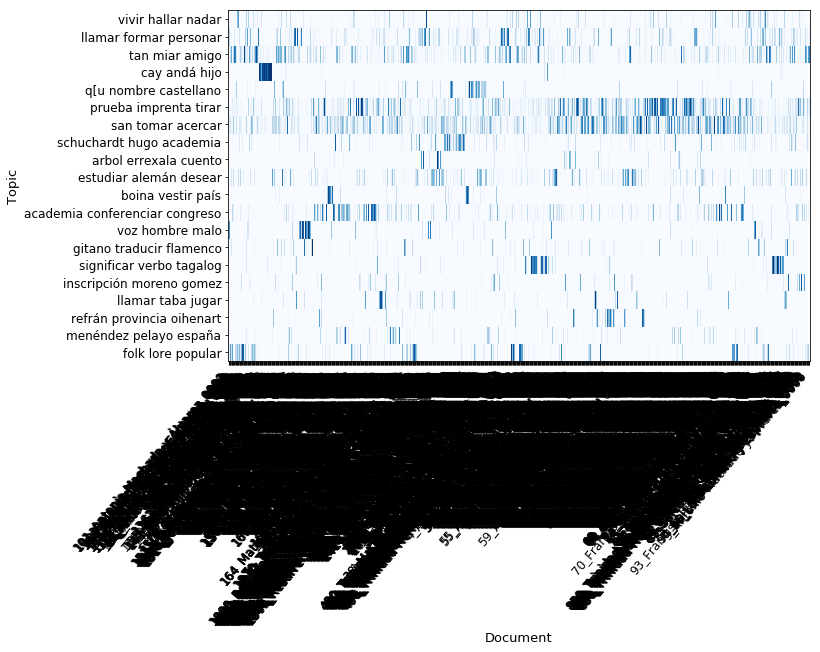

In [125]:
PlotDocumentTopics = visualization.PlotDocumentTopics(document_topics)
static_heatmap = PlotDocumentTopics.static_heatmap()
static_heatmap.show()

Dies kann auch als eine dynamische Heatmap angezeigt werden:

`show(PlotDocumentTopics.interactive_heatmap(), notebook_handle=True)`

#### Verteilung der Topics im einzelnen Dokument

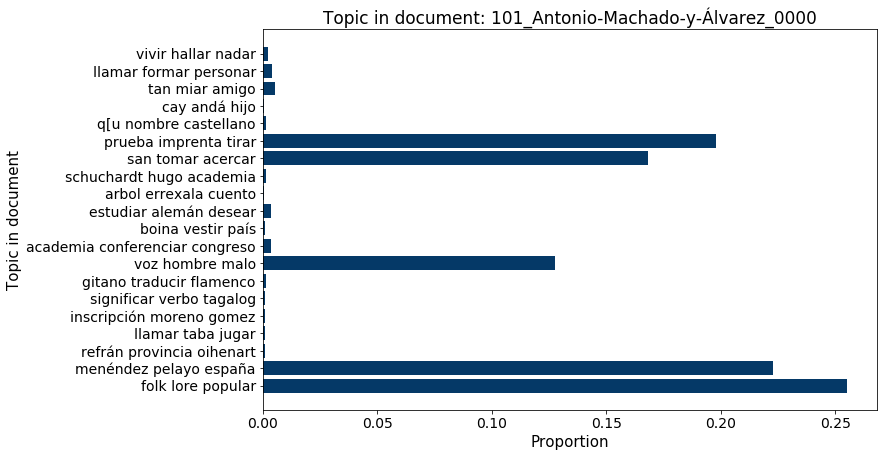

In [127]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index=0,
                                                                               describer='Topic in document')

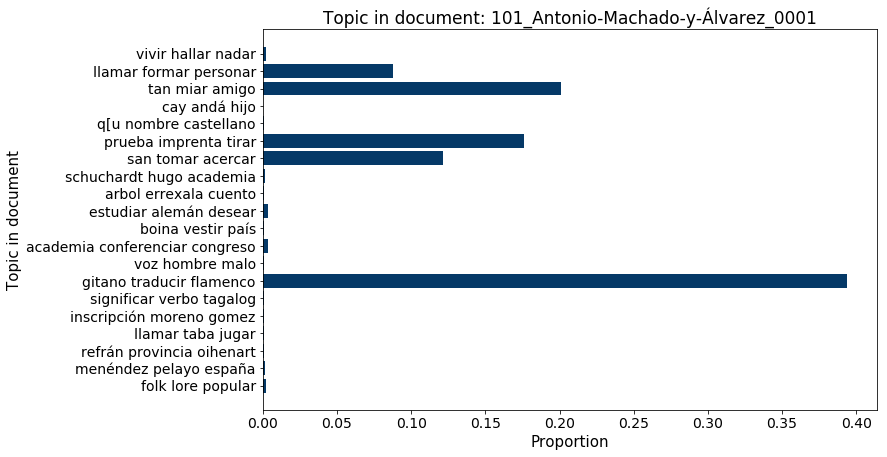

In [128]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index=1,
                                                                               describer='Topic in document')

#### Verteilung der Topics nach AbsenderInnen

In [129]:
from bokeh.palettes import Inferno11 as palette

In [130]:
PlotDocumentTopics = visualization.PlotDocumentTopics(document_topics_sender)
show(PlotDocumentTopics.interactive_heatmap(width=1000, height=700, major_label_text_font_size='13pt', palette=palette), notebook_handle=True)

In [131]:
help(visualization.PlotDocumentTopics(document_topics_sender))

Help on PlotDocumentTopics in module dariah_topics.visualization object:

class PlotDocumentTopics(builtins.object)
 |  PlotDocumentTopics(document_topics)
 |  
 |  Class to visualize document-topic matrix.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, document_topics)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  interactive_barchart_per_document(self, **kwargs)
 |      Plots an interactive barchart per document.
 |      
 |      Args:
 |          index Union(int, str): Index of document-topics matrix column or
 |              name of column.
 |          describer (str): Describer of what the plot shows, e.g. either document
 |              or topic.
 |          bar_color (str), optional: Color of bars. Defaults to ``#053967``.
 |          transpose_data (bool): If True. document-topics matrix will be transposed.
 |              Defaults to False.
 |          title (bool), optional: If True, figure will have a title in the format
 |          

#### Verteilung der Topics beim einzelnen AbsenderInnen

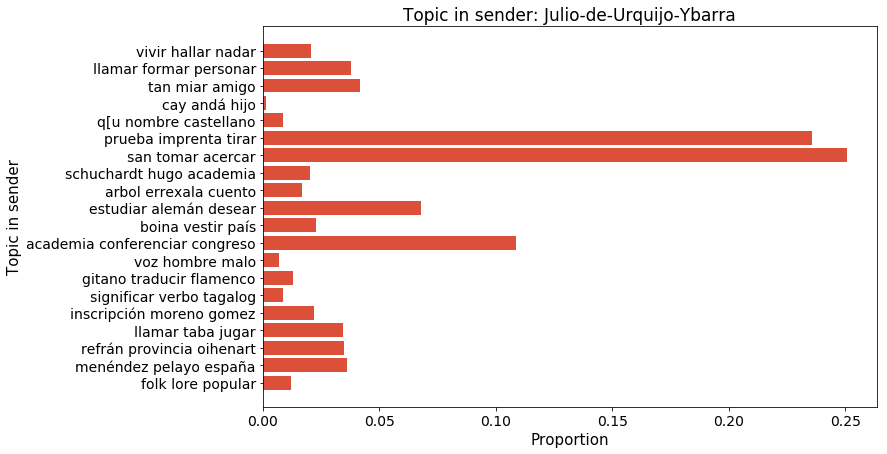

In [132]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index='Julio-de-Urquijo-Ybarra',
                                                                               describer='Topic in sender',
                                                                              color='#DC5039')

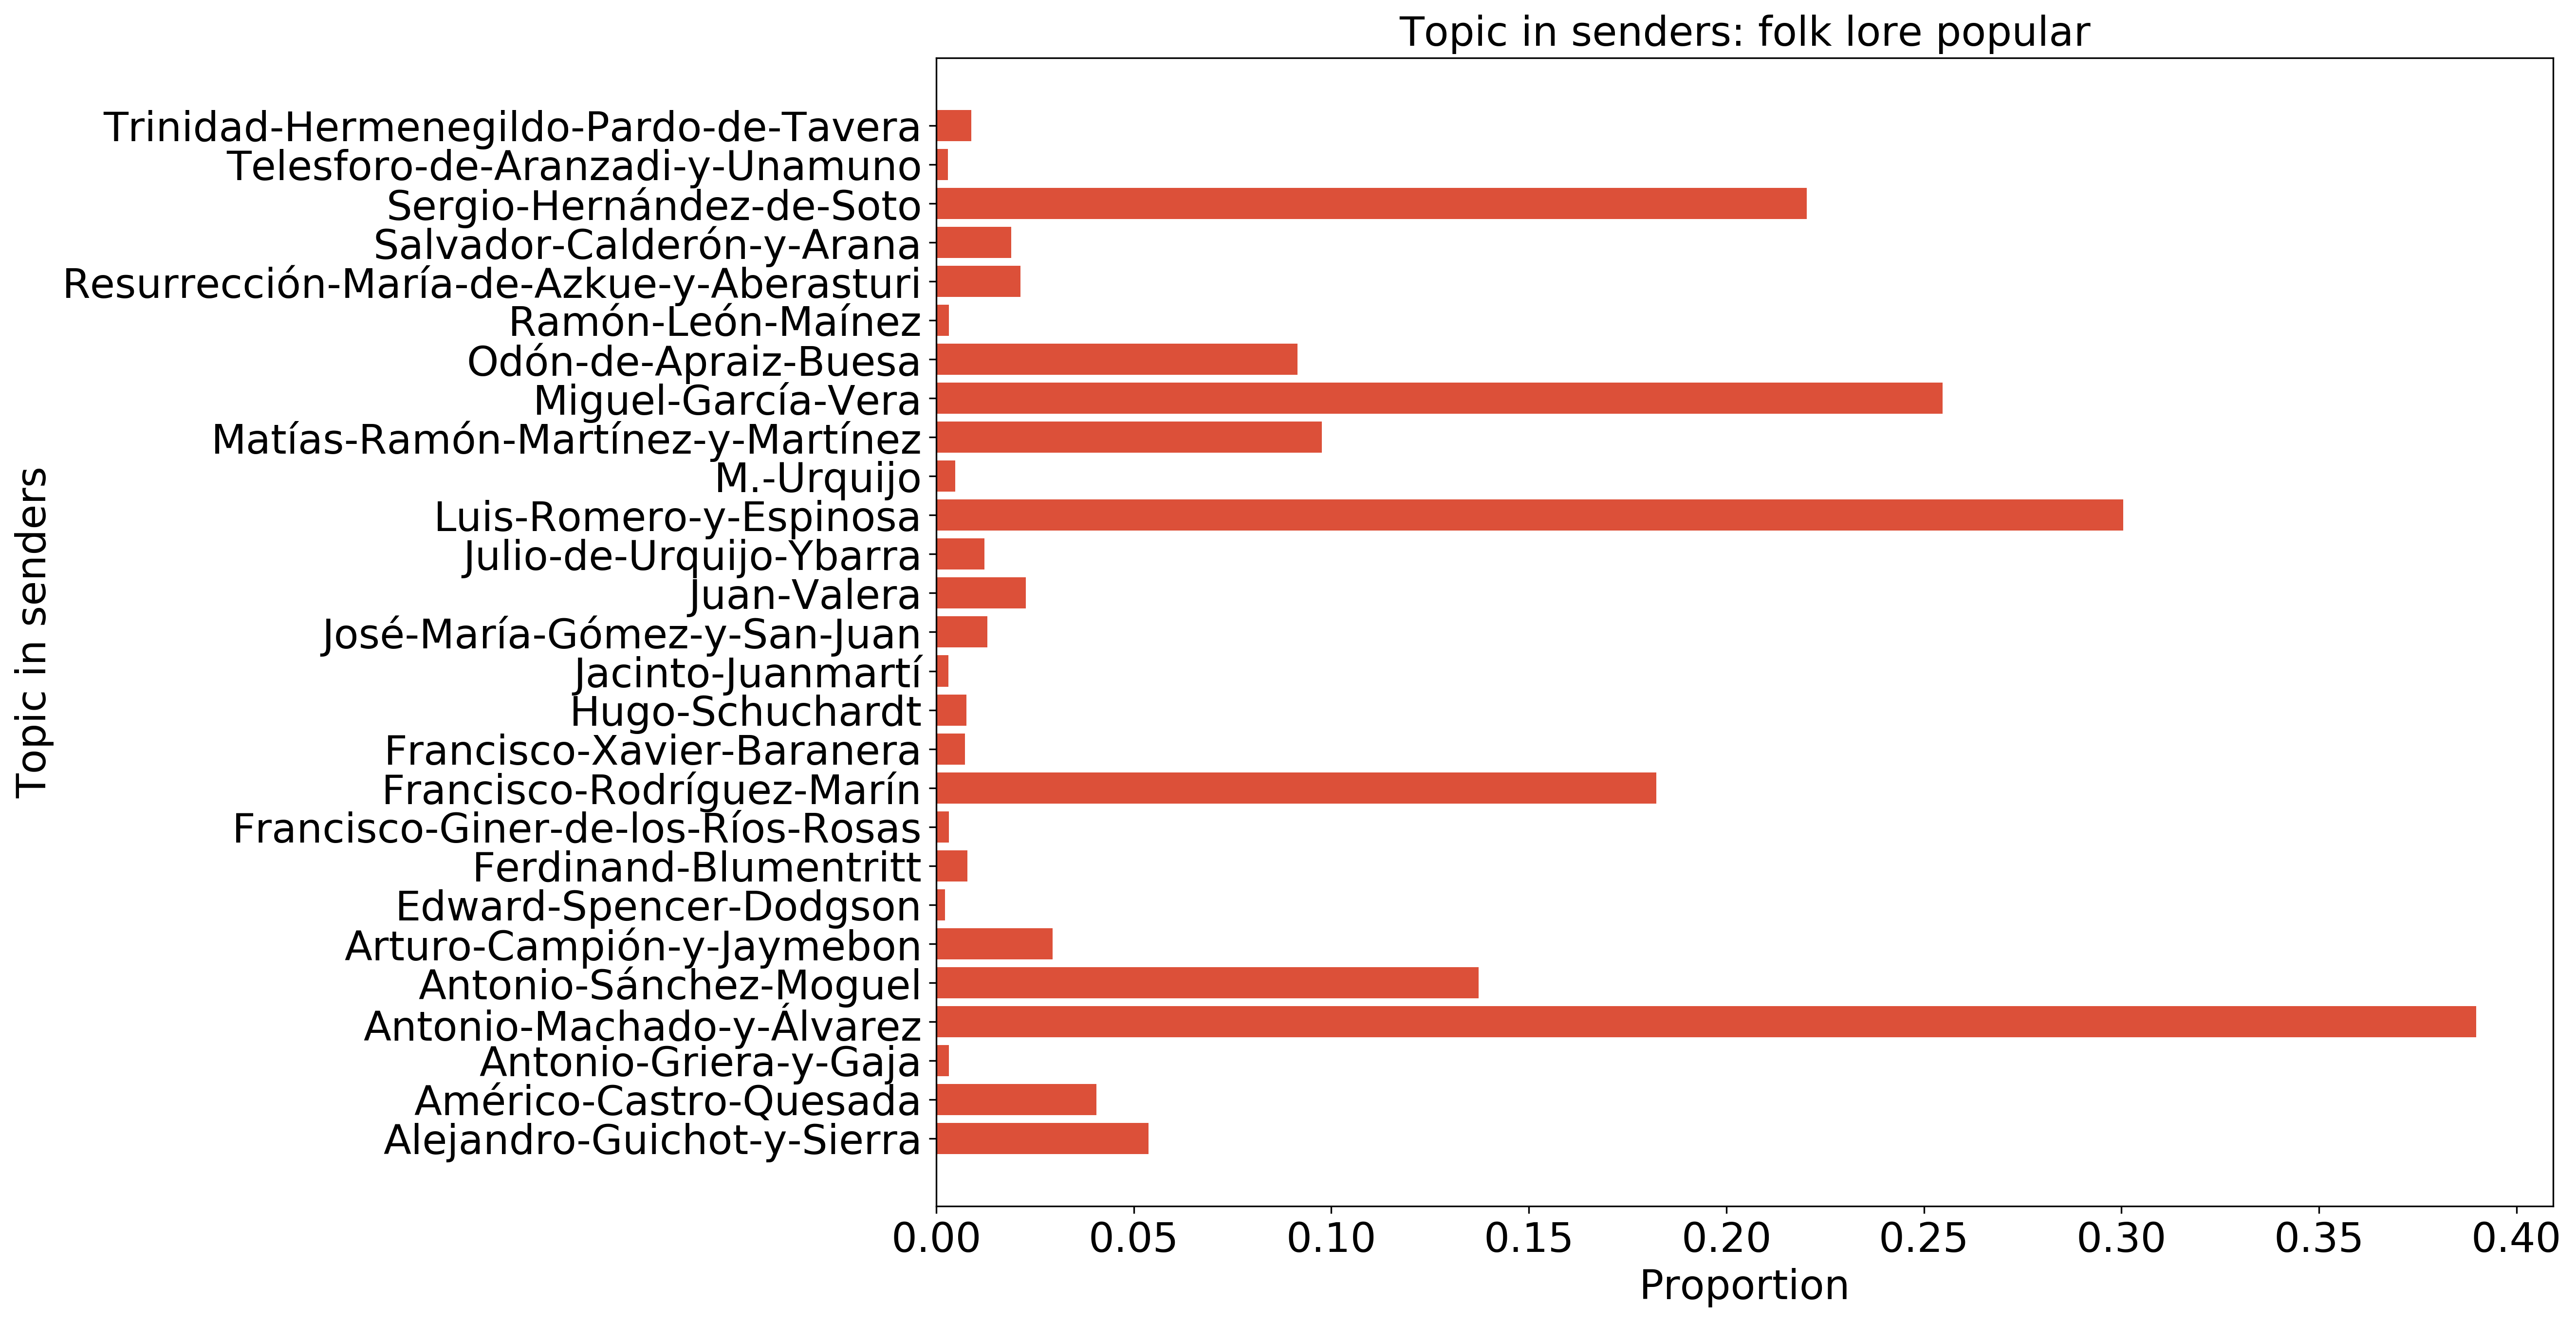

In [133]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_topic(index=0,
                                                                            describer='Topic in senders',
                                                                            figsize = (1000 / 70, 1000 / 96),
                                                                            labels_fontsize=20,
                                                                            title_fontsize=20,
                                                                            ticks_fontsize=20,
                                                                            dpi=300,
                                                                              color='#DC5039')

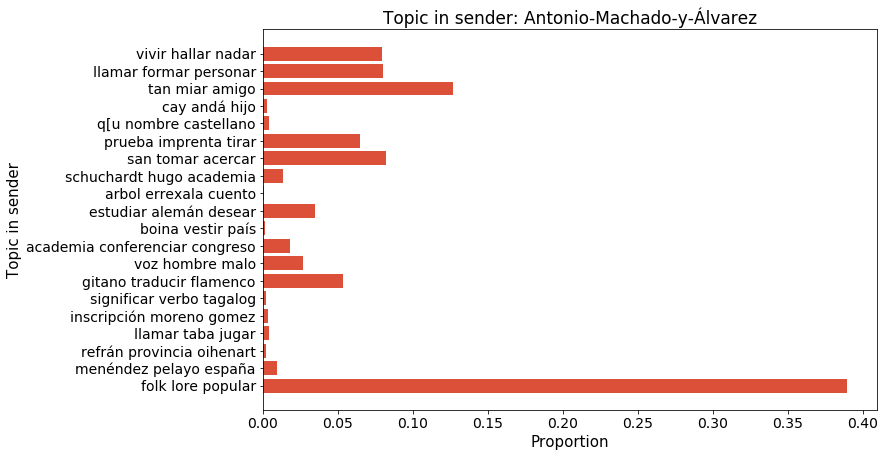

In [135]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index='Antonio-Machado-y-Álvarez',
                                                                               describer='Topic in sender',
                                                                              color='#DC5039')

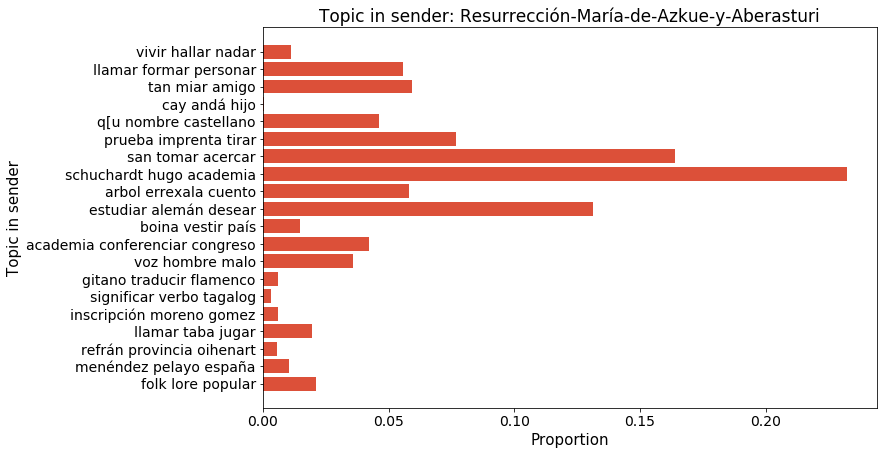

In [136]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index='Resurrección-María-de-Azkue-y-Aberasturi',
                                                                               describer='Topic in sender',
                                                                              color='#DC5039')

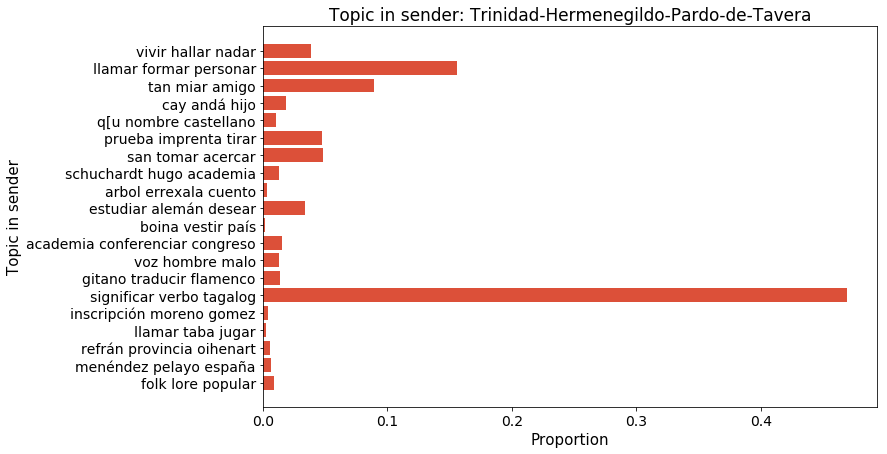

In [137]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index='Trinidad-Hermenegildo-Pardo-de-Tavera',
                                                                               describer='Topic in sender',
                                                                              color='#DC5039')

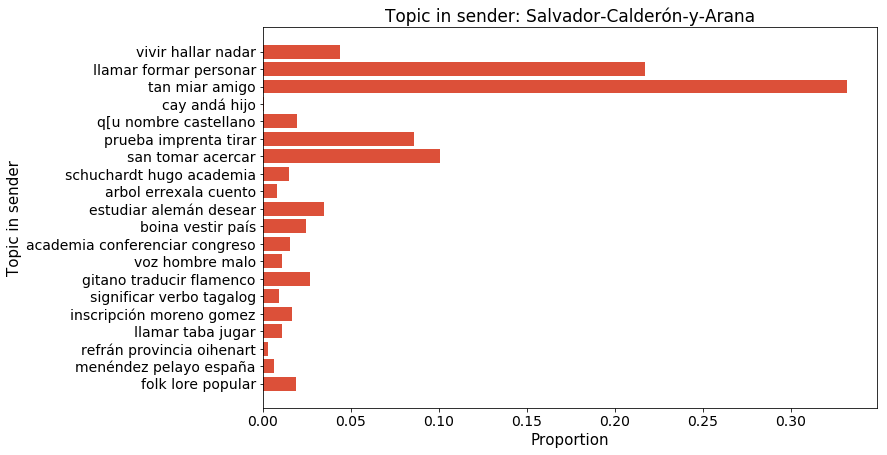

In [138]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index='Salvador-Calderón-y-Arana',
                                                                               describer='Topic in sender',
                                                                              color='#DC5039')

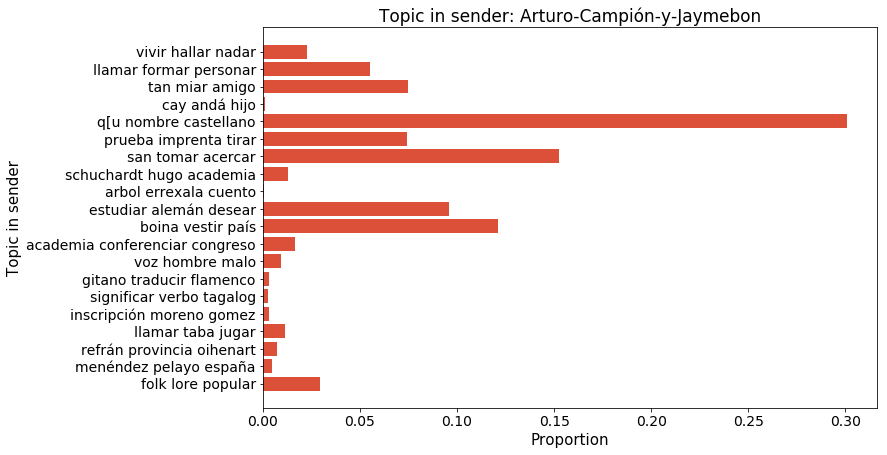

In [139]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index='Arturo-Campión-y-Jaymebon',
                                                                               describer='Topic in sender',
                                                                              color='#DC5039')